In [ ]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.optim as optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
GLOVE_DIR="./" #"../pre-trained-embdedding-models/glove.6B/"
dimension=100
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

## PyTorch Dataset and Model

In [ ]:
class dedupDataset(Dataset):
    """User defined class to build a dataset using Pytorch class Dataset."""
    
    def __init__(self, data, encoding, transform = None):
        """Method to initilaize variables.""" 
        self.data = data
        self.encoding = encoding

        self.transform=transform

    def __getitem__(self, index):
        w1, w2, isDuplicate = self.data.loc[index]
        
        e1 = self.encoding[w1.lower().strip()]
        e2 = self.encoding[w2.lower().strip()]

        E = torch.cat((torch.tensor(e1),torch.tensor(e2)))        

        if self.transform is not None:
            E = self.transform(E)

        return E, torch.tensor(isDuplicate).float()

    def __len__(self):
        return len(self.data)

In [ ]:
class NN(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.fc1 = nn.Linear(d*2, 100)
        self.fc2 = nn.Linear(100, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

## Data Preparation
### Remove all data with entries which do not have embeddings

 Next work -  doc2vec/train word2vec

In [ ]:
data_path = "dedup-data-6187_37728.csv"

df = pd.read_csv(data_path, usecols=['w1', 'w2', 'isDuplicate']).sample(frac=1).reset_index(drop=True)

In [ ]:
df['w1_has_embedding']=df['w1'].apply(lambda x:x.lower().strip() in embeddings_index)
df['w2_has_embedding']=df['w2'].apply(lambda x:x.lower().strip() in embeddings_index)

In [ ]:
df=df[df['w1_has_embedding']==True]
df=df[df['w2_has_embedding']==True]

df = df.drop(['w1_has_embedding', 'w2_has_embedding'], axis=1)
df = df.reset_index(drop=True)

In [ ]:
df_train=df[:int(0.7*len(df))].reset_index(drop=True)
df_test =df[int(0.7*len(df)):].reset_index(drop=True)

In [ ]:
df_train['isDuplicate'].value_counts()

0.0    6866
1.0    1035
Name: isDuplicate, dtype: int64

# Train pytorch NN

In [ ]:
model = NN(d=dimension).to(device)

In [ ]:
train_set, test_set = dedupDataset(df_train, embeddings_index), dedupDataset(df_test, embeddings_index)
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=len(df_test))


In [ ]:
# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

In [ ]:
def binary_acc(y_pred, y_ground):

    # print(y_pred, y_ground)  
    y_pred_tag = torch.round(y_pred)
    # print(y_pred_tag, y_ground)  


    correct_results_sum = (y_pred_tag == y_ground).sum().float()
    # print(correct_results_sum)
    acc = correct_results_sum/y_ground.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
epochs=65
#forward loop
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(train_loader):
    x_train,y_train = x_train.to(device), y_train.to(device)
    #calculate output
    output = model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    
    acc = binary_acc(output, y_train.reshape(-1,1))
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%5 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0	loss : 0.44416213035583496	 accuracy : 100.0
epoch 5	loss : 0.03259296342730522	 accuracy : 100.0
epoch 10	loss : 0.022105703130364418	 accuracy : 100.0
epoch 15	loss : 0.01323110330849886	 accuracy : 100.0
epoch 20	loss : 0.005642448086291552	 accuracy : 100.0
epoch 25	loss : 0.002199324779212475	 accuracy : 100.0
epoch 30	loss : 0.0008947678725235164	 accuracy : 100.0
epoch 35	loss : 0.000412608846090734	 accuracy : 100.0
epoch 40	loss : 0.000188606878509745	 accuracy : 100.0
epoch 45	loss : 8.309232362080365e-05	 accuracy : 100.0
epoch 50	loss : 3.6776742490474135e-05	 accuracy : 100.0
epoch 55	loss : 1.6987467461149208e-05	 accuracy : 100.0
epoch 60	loss : 7.629423635080457e-06	 accuracy : 100.0


In [ ]:
y_truth_list = []
y_pred_list = []
model.eval()
with torch.no_grad():
  for j,(x_test,y_test) in enumerate(test_loader):
      x_test,y_test = x_test.to(device), y_test.to(device)
      #calculate output
      output = model(x_test)
  
      acc = binary_acc(output, y_test.reshape(-1,1))



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
acc

tensor(98., device='cuda:0')

In [ ]:
y_pred = torch.round(output.reshape(-1))

In [ ]:
y_pred_arr = np.asarray(y_pred.cpu())
y_test_arr = np.asarray(y_test.cpu())

In [ ]:
from sklearn.metrics import roc_curve, classification_report

In [ ]:
print(classification_report(y_test_arr, y_pred_arr))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2909
         1.0       0.95      0.93      0.94       478

    accuracy                           0.98      3387
   macro avg       0.97      0.96      0.97      3387
weighted avg       0.98      0.98      0.98      3387



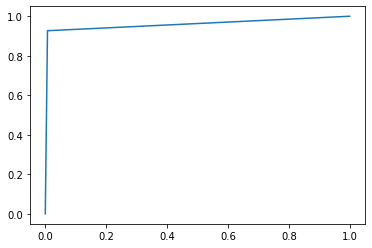

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_arr, y_pred_arr)
plt.plot(fpr,tpr)
plt.show()

In [ ]:
print(model)

NN(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
